In [54]:
!pip install -e ..

Obtaining file:///root/allen/aics/modeling/gregj/projects/pytorch_integrated_cell
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.0 requires cython, which is not installed.
  Found existing installation: pytorch-integrated-cell 0.1
    Uninstalling pytorch-integrated-cell-0.1:
      Successfully uninstalled pytorch-integrated-cell-0.1
  Running setup.py develop for pytorch-integrated-cell


### Given a benchmark directory (as defined by the variable **benchmark_dir**), the model looks at the loggers for the reference structure in each model directory, and reports the average epoch time in a bar graph

note: The stats for the current machines are as follows:  
**dgx**: 8x 16gb V100s, ssd caching from the isilon  
**n70**: 4x 12gb Titan X pascal, isilon  
**gjp1**: 3x 12gb Titan X pascal, isilon  
**gjp2**: 2x 16gb GP100s pascal (I think), isilon  

Integrated cell training benchmarks:
dgx
	batch size:	16
	n gpus:		1
n70
	batch size:	16
	n gpus:		1
gjp1
	batch size:	16
	n gpus:		1


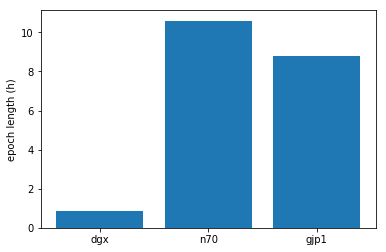

In [53]:
import integrated_cell.SimpleLogger as SimpleLogger
import pickle
import os
import numpy as np
import glob

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

benchmark_dir = '/root/results/integrated_cell/benchmarks/*/'

model_dirs = glob.glob(benchmark_dir)

model_dirs.sort(key=os.path.getmtime, reverse=True)


import pdb

def get_epoch_time(model_dir):
    logger_file = '{0}/logger_tmp.pkl'.format(model_dir)
    
    if not os.path.exists(logger_file):
        print('Could not find logger at ' + logger_file)
        return

    logger = pickle.load( open( logger_file, "rb" ) )

    iter_times = logger.log['time']
    iter_epoch = logger.log['epoch']
    
    uepochs = np.unique(iter_epoch)
    
    epoch_time = np.zeros(len(uepochs))
    
    for i, epoch in enumerate(uepochs):
        epoch_time[i] = np.sum(np.array(iter_times)[iter_epoch == epoch])
    
    return uepochs, epoch_time
    
def get_batch_size(model_dir):
    opt = pickle.load( open( '{0}/opt.pkl'.format(model_dir), "rb" ) )
    return opt.batch_size
    
def get_n_gpus(model_dir):
    opt = pickle.load( open( '{0}/opt.pkl'.format(model_dir), "rb" ) )
    return len(opt.gpu_ids)
    
avg_epoch_len = list()
dir_names = list()
batch_sizes = list()
n_gpus = list()
for i, model_dir in enumerate(model_dirs):
    dir_name = os.path.basename(os.path.split(model_dir)[0])
    
    sub_model_dir = model_dir + os.sep + 'ref_model'
    
    n_gpus += [get_n_gpus(sub_model_dir)]
    batch_sizes += [get_batch_size(sub_model_dir)]
    epoch, epoch_time = get_epoch_time(sub_model_dir) 
    mean_epoch_time = np.mean(epoch_time)/60/60 #in hours
    avg_epoch_len += [mean_epoch_time]
    dir_names += [dir_name]
    
    

#ghetto printing
print('Integrated cell training benchmarks:')    
for dir_name, batch_size, n_gpu in zip(dir_names, batch_sizes, n_gpus):
    print(dir_name)
    print('\tbatch size:\t{0}\n\tn gpus:\t\t{1}'.format(batch_size, n_gpu))
    
positions = range(0, len(avg_epoch_len))    

fig, ax = plt.subplots()
plt.bar(positions, np.array(avg_epoch_len))

plt.ylabel('epoch length (h)')
plt.xticks(positions)
ax.set_xticklabels(dir_names)
plt.show()
#     except:
#         print('could not load ' + model_dir)